In [5]:
import numpy as np  
import matplotlib.pyplot as plt  
import scipy 
import math  


# finite difference method to calculate the second derivative of a function
def d2f(f, dz, Nz):
    sol = np.zeros((Nz))  # Initialize solution array
    for i in range(1, Nz - 2):
        sol[i] = (f[i - 1] - 2 * f[i] + f[i + 1]) / (dz * dz)
    # Apply boundary conditions at i=0
    sol[0] = (2 * f[0] - 5 * f[1] + 4 * f[2] - f[3]) / (dz * dz)
    # Apply boundary conditions at i=Nz-1
    sol[Nz - 1] = (2 * f[Nz - 1] - 5 * f[Nz - 2] + 4 * f[Nz - 3] - f[Nz - 4]) / (dz * dz)
    return sol

def df(f,dz,Nz):
    sol = np.zeros((Nz))
    i=0
    sol[i]=((2*f[i])-(5*f[i+1])+(4*f[i+2])-f[i+3])/(dz*dz)
    i=Nz-1
    sol[i]=((2*f[i])-(5*f[i-1])+(4*f[i-2])-f[i-3])/(dz*dz)
    for i in range(1,Nz-2):
        sol[i]=(f[i-1]+(-2*f[i])+f[i+1])/(dz*dz)
    return sol

def solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D):
    #intials()
    Br=[]
    Bphi=[]
    decay=[]

    if 0 in time_plot:
        Br.append(Br_t0)
        Bphi.append(Bphi_t0)

    
    for j in range(0, Nt + 1):
        
        k1r = dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,dt*j)
        k1phi = dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,dt*j)
        
        k2r = dBrdt(Br_t0+k1r*dt/2, Bphi_t0+k1phi*dt/2, z,D,alpha,dz,Nz,vzfn,dt*j)
        k2phi = (dBphidt(Br_t0+k1r*dt/2, Bphi_t0+k1phi*dt/2, z,D,alpha,dz,Nz,vzfn,dt*j)) 
        
        k3r = (dBrdt(Br_t0+k2r*dt/2,Bphi_t0+k2phi*dt/2,z,D,alpha,dz,Nz,vzfn,dt*j)) 
        k3phi = (dBphidt(Br_t0+k2r*dt/2,Bphi_t0+k2phi*dt/2,z,D,alpha,dz,Nz,vzfn,dt*j)) 
        
        k4r = (dBrdt(Br_t0+k3r*dt,Bphi_t0+k3phi*dt/2,z,D,alpha,dz,Nz,vzfn,dt*j)) 
        k4phi = (dBphidt(Br_t0+k3r*dt/2,Bphi_t0+k3phi*dt,z,D,alpha,dz,Nz,vzfn,dt*j))
        Br_t0 = Br_t0 + ((dt / 6.0) * (k1r +( 2 * k2r) + (2 * k3r) + k4r))
        
        Bphi_t0 = Bphi_t0 + ((dt / 6.0) * (k1phi + (2 * k2phi) + (2 * k3phi) + k4phi))
               
        #(Anti Symmetric Ghost Zone)
        Bphi_t0[1]=Bphi_z0
        Br_t0[Nz-2]=Br_zf
        Br_t0[1]=Br_z0
        Bphi_t0[Nz-2]=Bphi_zf
        Br_t0[Nz-1]=Br_z0-Br_t0[Nz-3]
        Bphi_t0[Nz-1]=Bphi_z0-Bphi_t0[Nz-3]
        Br_t0[0]=Br_z0-Br_t0[2]
        Bphi_t0[0]=Bphi_z0-Bphi_t0[2]

        decay.append(np.log10(np.sqrt((np.mean(Br_t0))**2+(np.mean(Bphi_t0))**2)))

        if j in time_plot:
            Br.append(Br_t0)
            Bphi.append(Bphi_t0)
            #B_pitch.append(np.copy(B))

    pitch=np.arctan(np.array(Br)/np.array(Bphi))
    return Br,Bphi,pitch,decay


def plotfn(Br, Bphi, pitch, decay, time_plot,t,z,Nz):
    m, b = np.polyfit(t, decay, 1)

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))  
    
    for i in range(len(time_plot)):
        ax[0, 0].plot(z[1:Nz-1], Br[i][1:Nz-1], label=f't={time_plot[i]}')
        ax[0, 1].plot(z[1:Nz-1], Bphi[i][1:Nz-1], label=f't={time_plot[i]}')
        ax[1, 1].plot(z[1:Nz-1], pitch[i][1:Nz-1], label=f't={time_plot[i]}')
    
    ax[0, 0].set_xlabel('z')
    ax[0, 0].set_ylabel('Br')
    ax[0, 0].set_title('Br vs z')
    ax[0, 0].legend()
    
    ax[0, 1].set_xlabel('z')
    ax[0, 1].set_ylabel(r'$B_{\phi}$')
    ax[0, 1].set_title(r'$B_{\phi}$ vs z')
    ax[0, 1].legend()

    ax[1, 0].scatter(t, decay)
    ax[1, 0].plot(t, m*t+b,color='Red', label='linear fit')
    ax[1, 0].set_xlabel('t')
    ax[1, 0].set_ylabel('log(B)')
    ax[1, 0].set_title('exponential decay rate')
    
    #ax[1, 1].plot(z, pitch)
    ax[1, 1].set_xlabel('z')
    ax[1, 1].set_ylabel('pitch angle')
    ax[1, 1].set_title('pitch angle vs z')
    
    plt.tight_layout()
    plt.show()
    print("The Decay rate is",np.round((m*np.log(10)),4))



def D_c(solve2,precision):
    D=0
    h=2
    while h>precision:  
        drate=-1 #dummy value
        print('current |D| =',D)
        while drate<0:
            Br,Bphi,pitch,decay=solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,-D)
            m, c = np.polyfit(t, decay , 1)
            drate=m*np.log(10)
            print('|D| =',D,' | decay rate =',drate)
            D=D+h   
        D=D-2*h
        h=h/2
    print("Critical dynamo number, |D_c| =",D+h/2)
    #return D+h/2


## constant Vz = 0.80

/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


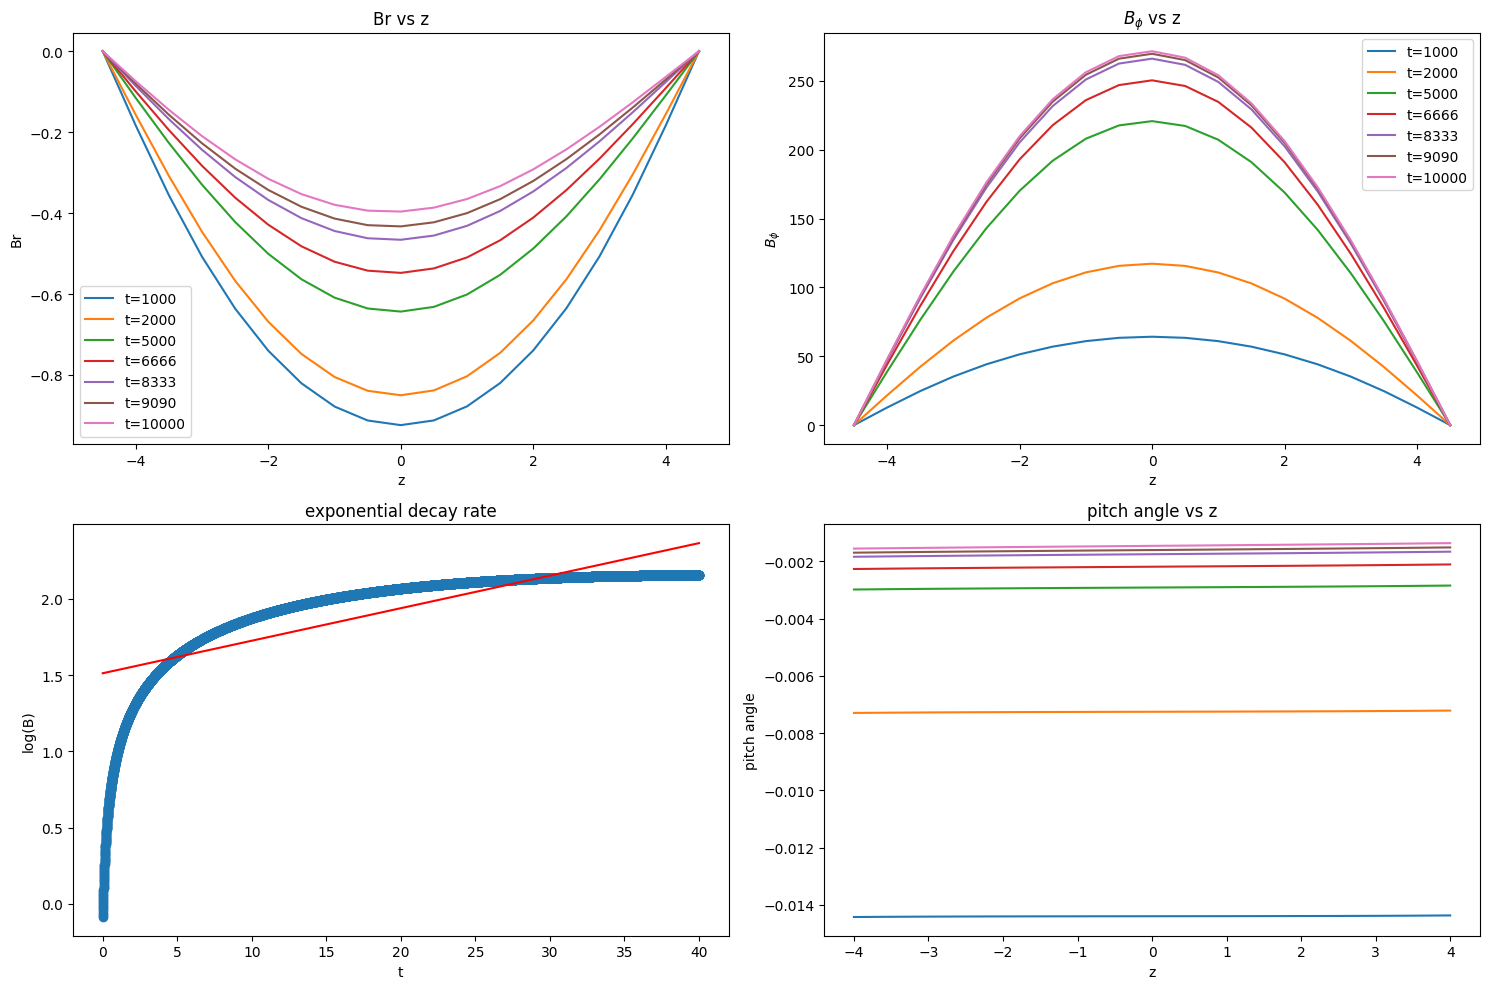

The Decay rate is 0.0491


In [45]:
def Bphi_t0(z):
    return np.cos((np.pi/2)*z/5)

def Br_t0(z):
    return np.cos((np.pi/2)*z/5+(np.pi))


# def vzfn(tv):
#     return tv/(4.1*np.sqrt(tv+0.001))

# def vzfn(tv):
#     return np.sin(tv/80)
def vzfn(tv):
    return 0.80


def alphafn(z):
    return (2*np.sin(np.pi*z/1000000))

# def alphafn(z):
#     return (np.sin(np.pi*z/0.761))


def dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Br_t0,dz,Nz)-df(alpha*alphafn(z)*Bphi_t0,dz,Nz)-df(vzfn(tv)*Br_t0,dz,Nz))
def dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Bphi_t0,dz,Nz)+((D/alpha)*Br_t0)-df(vzfn(tv)*Bphi_t0,dz,Nz))


# z0 = 0.0  # start of spatial region in z
# zf = 10.0  # end of spatial domain in z
z0 = -5  # start of spatial region in z
zf = 5  # end of spatial domain in z

t0=0.0
tf = 40 
Nz = 21  # Number of spatial grid points
Nt = 10000  # Number of time steps
dz = (zf - z0) / (Nz - 1)  # Spatial step size
dt = tf / Nt  # Time step size



z = np.linspace(z0, zf, Nz)
t = np.linspace(t0, tf, Nt+1)

Br_t0=Br_t0(z)
Bphi_t0=Bphi_t0(z)

Bphi_z0=0
Bphi_zf=0
Br_z0=0
Br_zf=0

#print(Bphi_z0,Bphi_zf,Br_z0,Br_zf)
time_plot=[int(Nt/10),int(Nt/5),int(Nt/2),int(Nt/1.5),int(Nt/1.2),int(Nt/1.1),Nt]



# D, alpha = -5, 1
D, alpha = -17.10, 1

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)

## Vz=0

/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


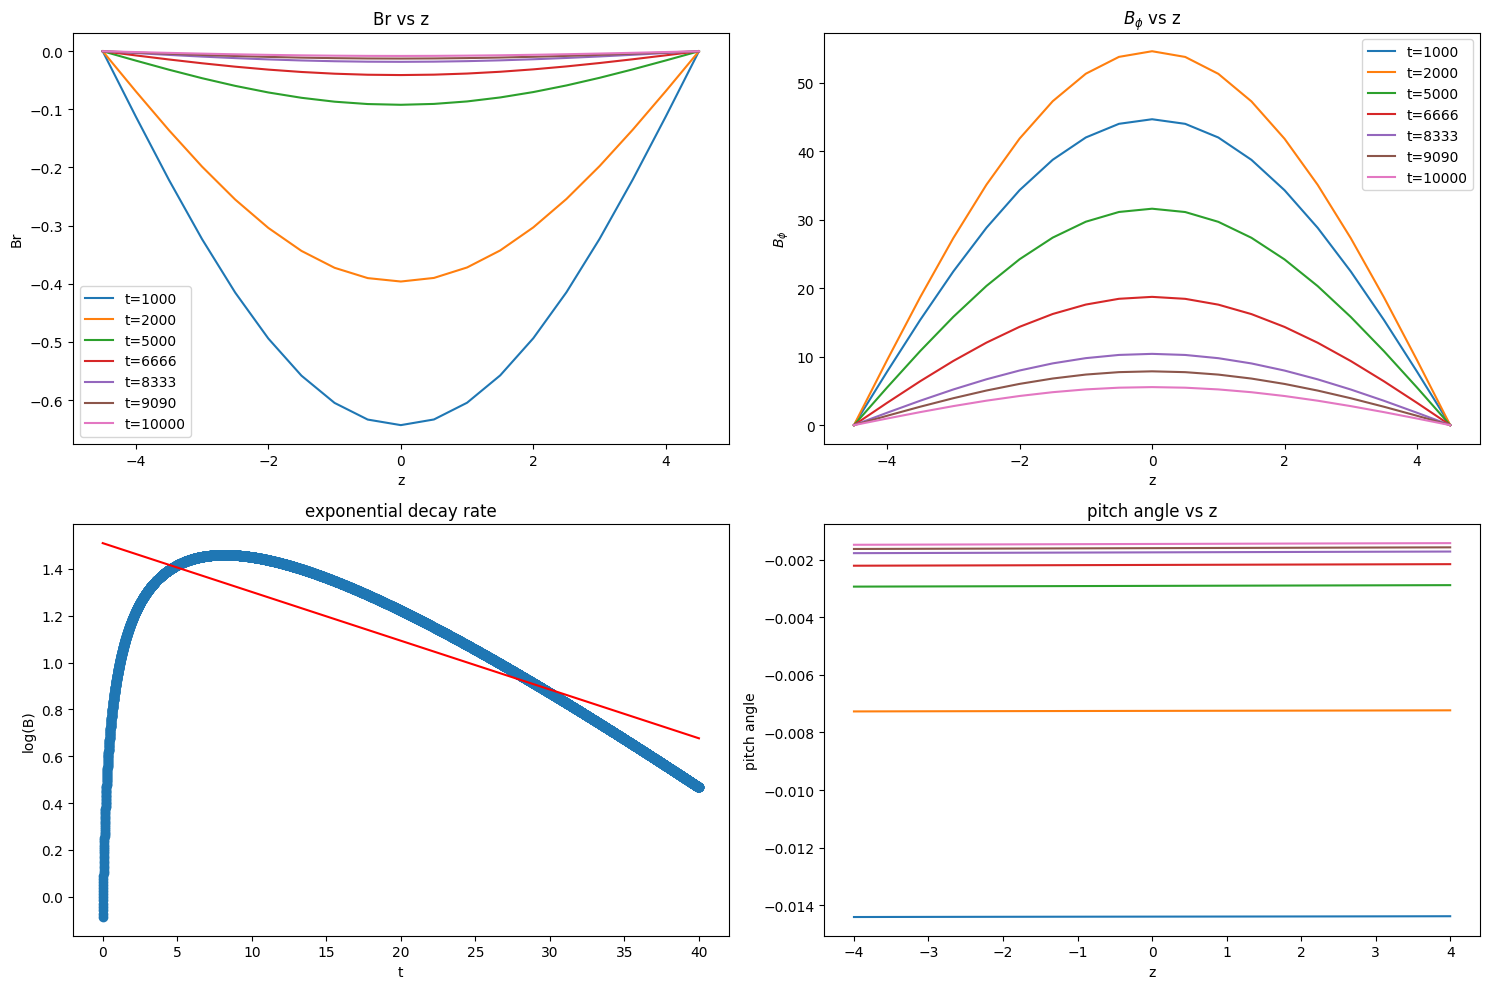

The Decay rate is -0.0479


In [62]:
def Bphi_t0(z):
    return np.cos((np.pi/2)*z/5)

def Br_t0(z):
    return np.cos((np.pi/2)*z/5+(np.pi))


# def vzfn(tv):
#     return tv/(4.1*np.sqrt(tv+0.001))

# def vzfn(tv):
#     return np.sin(tv/80)
def vzfn(tv):
    return 0.80


def alphafn(z):
    return (2*np.sin(np.pi*z/1000000))

# def alphafn(z):
#     return (np.sin(np.pi*z/0.761))


def dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Br_t0,dz,Nz)-df(alpha*alphafn(z)*Bphi_t0,dz,Nz))
def dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Bphi_t0,dz,Nz)+((D/alpha)*Br_t0))


# z0 = 0.0  # start of spatial region in z
# zf = 10.0  # end of spatial domain in z
z0 = -5  # start of spatial region in z
zf = 5  # end of spatial domain in z

t0=0.0
tf = 40 
Nz = 21  # Number of spatial grid points
Nt = 10000  # Number of time steps
dz = (zf - z0) / (Nz - 1)  # Spatial step size
dt = tf / Nt  # Time step size



z = np.linspace(z0, zf, Nz)
t = np.linspace(t0, tf, Nt+1)

Br_t0=Br_t0(z)
Bphi_t0=Bphi_t0(z)

Bphi_z0=0
Bphi_zf=0
Br_z0=0
Br_zf=0

#print(Bphi_z0,Bphi_zf,Br_z0,Br_zf)
time_plot=[int(Nt/10),int(Nt/5),int(Nt/2),int(Nt/1.5),int(Nt/1.2),int(Nt/1.1),Nt]



# D, alpha = -5, 1
D, alpha = -17.10, 1

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)

### $V_z$ is a function of z

/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


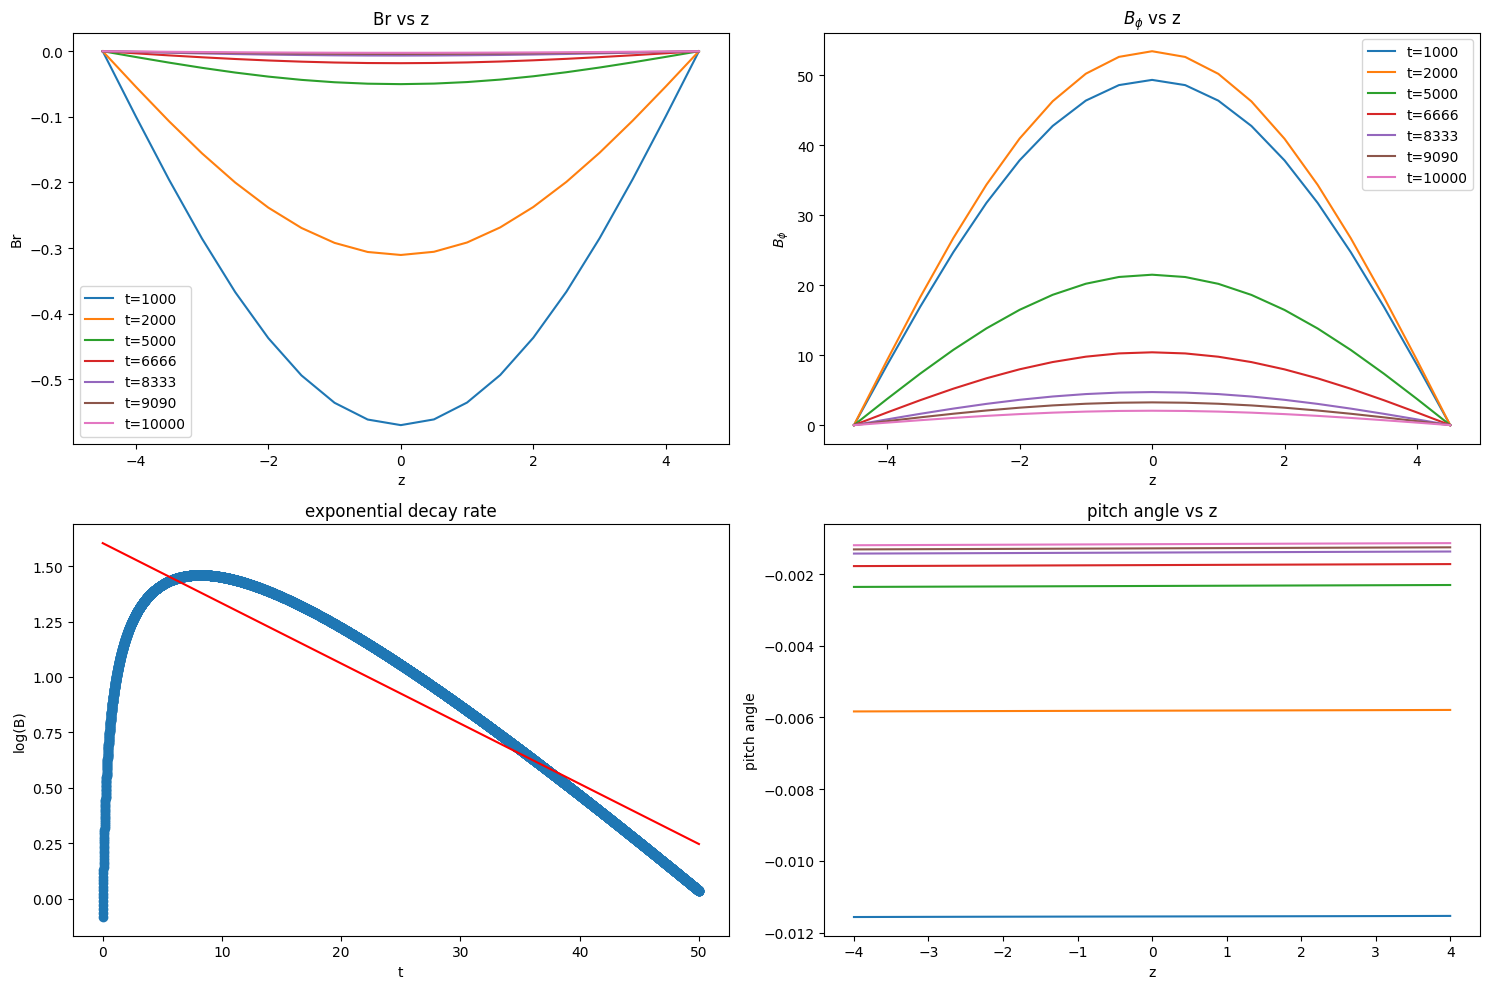

The Decay rate is -0.0625


In [133]:
def Bphi_t0(z):
    return np.cos((np.pi/2)*z/5)

def Br_t0(z):
    return np.cos((np.pi/2)*z/5+(np.pi))


# def vzfn(tv):
#     return tv/(4.1*np.sqrt(tv+0.001))

# def vzfn(tv):
#     return np.sin(tv/80)

vz=0.8
h=100000
def vzfn(tv,z):
    return vz*z/h


def alphafn(z):
    return (2*np.sin(np.pi*z/1000000))

# def alphafn(z):
#     return (np.sin(np.pi*z/0.761))


def dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Br_t0,dz,Nz)-df(alpha*alphafn(z)*Bphi_t0,dz,Nz)-df(vzfn(tv,z)*Br_t0,dz,Nz))
def dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Bphi_t0,dz,Nz)+((D/alpha)*Br_t0)-df(vzfn(tv,z)*Bphi_t0,dz,Nz))


# z0 = 0.0  # start of spatial region in z
# zf = 10.0  # end of spatial domain in z
z0 = -5  # start of spatial region in z
zf = 5  # end of spatial domain in z

t0=0.0
tf = 50 
Nz = 21  # Number of spatial grid points
Nt = 10000  # Number of time steps
dz = (zf - z0) / (Nz - 1)  # Spatial step size
dt = tf / Nt  # Time step size



z = np.linspace(z0, zf, Nz)
t = np.linspace(t0, tf, Nt+1)

Br_t0=Br_t0(z)
Bphi_t0=Bphi_t0(z)

Bphi_z0=0
Bphi_zf=0
Br_z0=0
Br_zf=0

#print(Bphi_z0,Bphi_zf,Br_z0,Br_zf)
time_plot=[int(Nt/10),int(Nt/5),int(Nt/2),int(Nt/1.5),int(Nt/1.2),int(Nt/1.1),Nt]



# D, alpha = -5, 1
D, alpha = -17.10, 1

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)

## $V_z$ is a linear function of time

/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


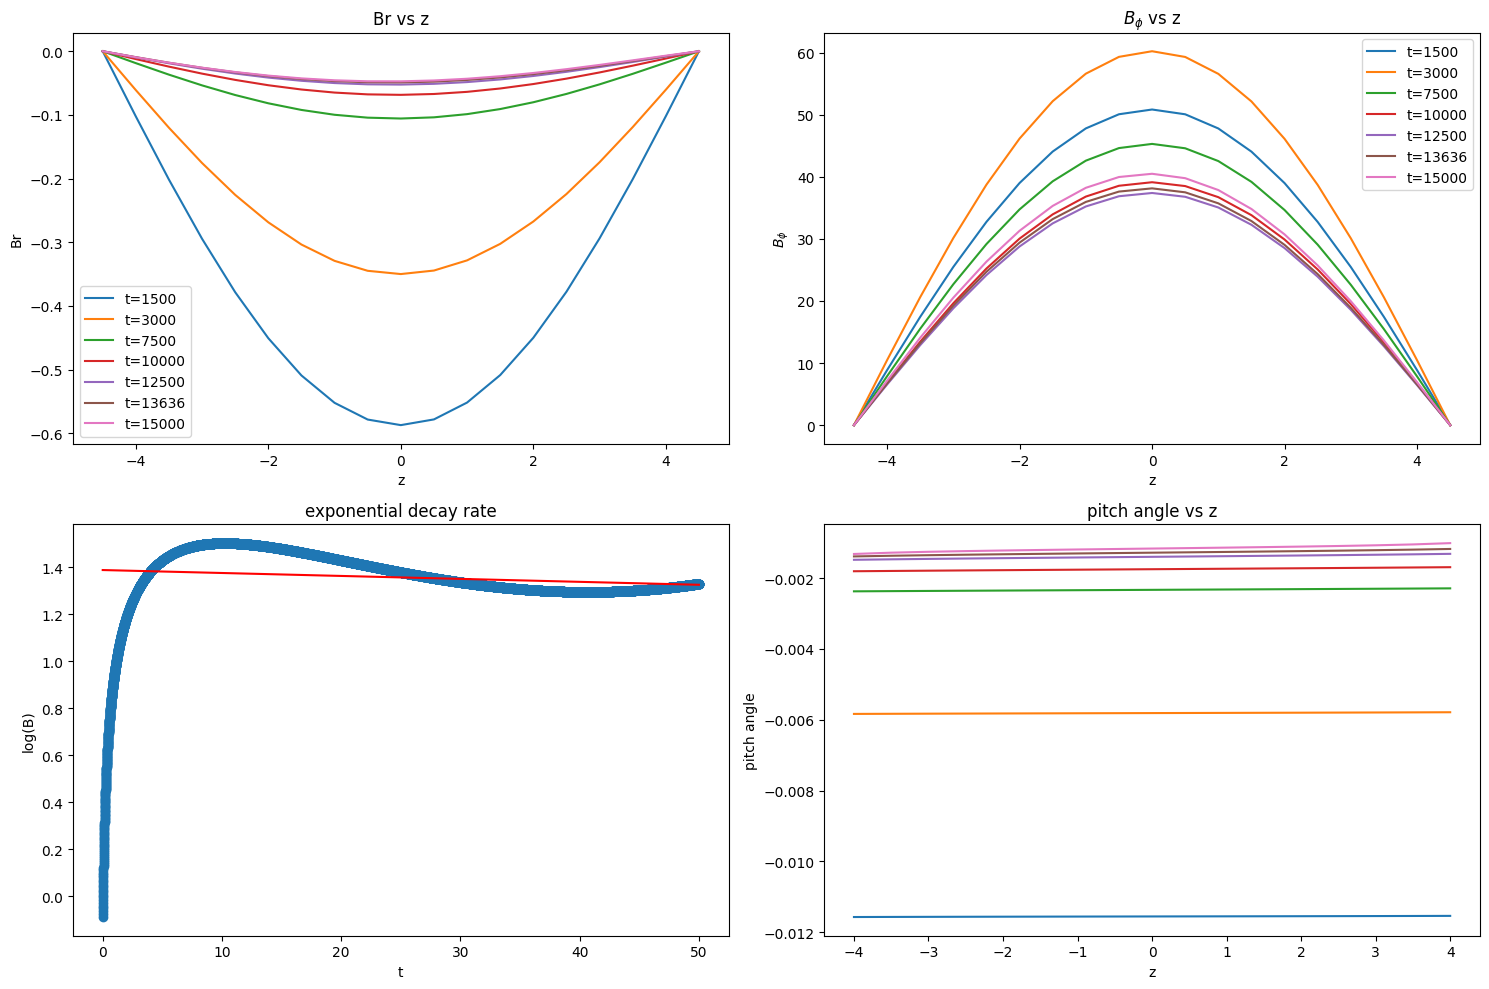

The Decay rate is -0.0029


In [87]:
def Bphi_t0(z):
    return np.cos((np.pi/2)*z/5)

def Br_t0(z):
    return np.cos((np.pi/2)*z/5+(np.pi))


# def vzfn(tv):
#     return tv/(4.1*np.sqrt(tv+0.001))

# def vzfn(tv):
#     return np.sin(tv/80)
def vzfn(tv):
    return tv/51


def alphafn(z):
    return (2*np.sin(np.pi*z/1000000))

# def alphafn(z):
#     return (np.sin(np.pi*z/0.761))


def dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Br_t0,dz,Nz)-df(alpha*alphafn(z)*Bphi_t0,dz,Nz)-df(vzfn(tv)*Br_t0,dz,Nz))
def dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Bphi_t0,dz,Nz)+((D/alpha)*Br_t0)-df(vzfn(tv)*Bphi_t0,dz,Nz))


# z0 = 0.0  # start of spatial region in z
# zf = 10.0  # end of spatial domain in z
z0 = -5  # start of spatial region in z
zf = 5  # end of spatial domain in z

t0=0.0
tf = 50 
Nz = 21  # Number of spatial grid points
Nt = 15000  # Number of time steps
dz = (zf - z0) / (Nz - 1)  # Spatial step size
dt = tf / Nt  # Time step size



z = np.linspace(z0, zf, Nz)
t = np.linspace(t0, tf, Nt+1)

Br_t0=Br_t0(z)
Bphi_t0=Bphi_t0(z)

Bphi_z0=0
Bphi_zf=0
Br_z0=0
Br_zf=0

#print(Bphi_z0,Bphi_zf,Br_z0,Br_zf)
time_plot=[int(Nt/10),int(Nt/5),int(Nt/2),int(Nt/1.5),int(Nt/1.2),int(Nt/1.1),Nt]



# D, alpha = -5, 1
D, alpha = -17.10, 1

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)

## $V_z(t) = \frac{L}{1 + e^{-k(t - t_0)}}$


/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


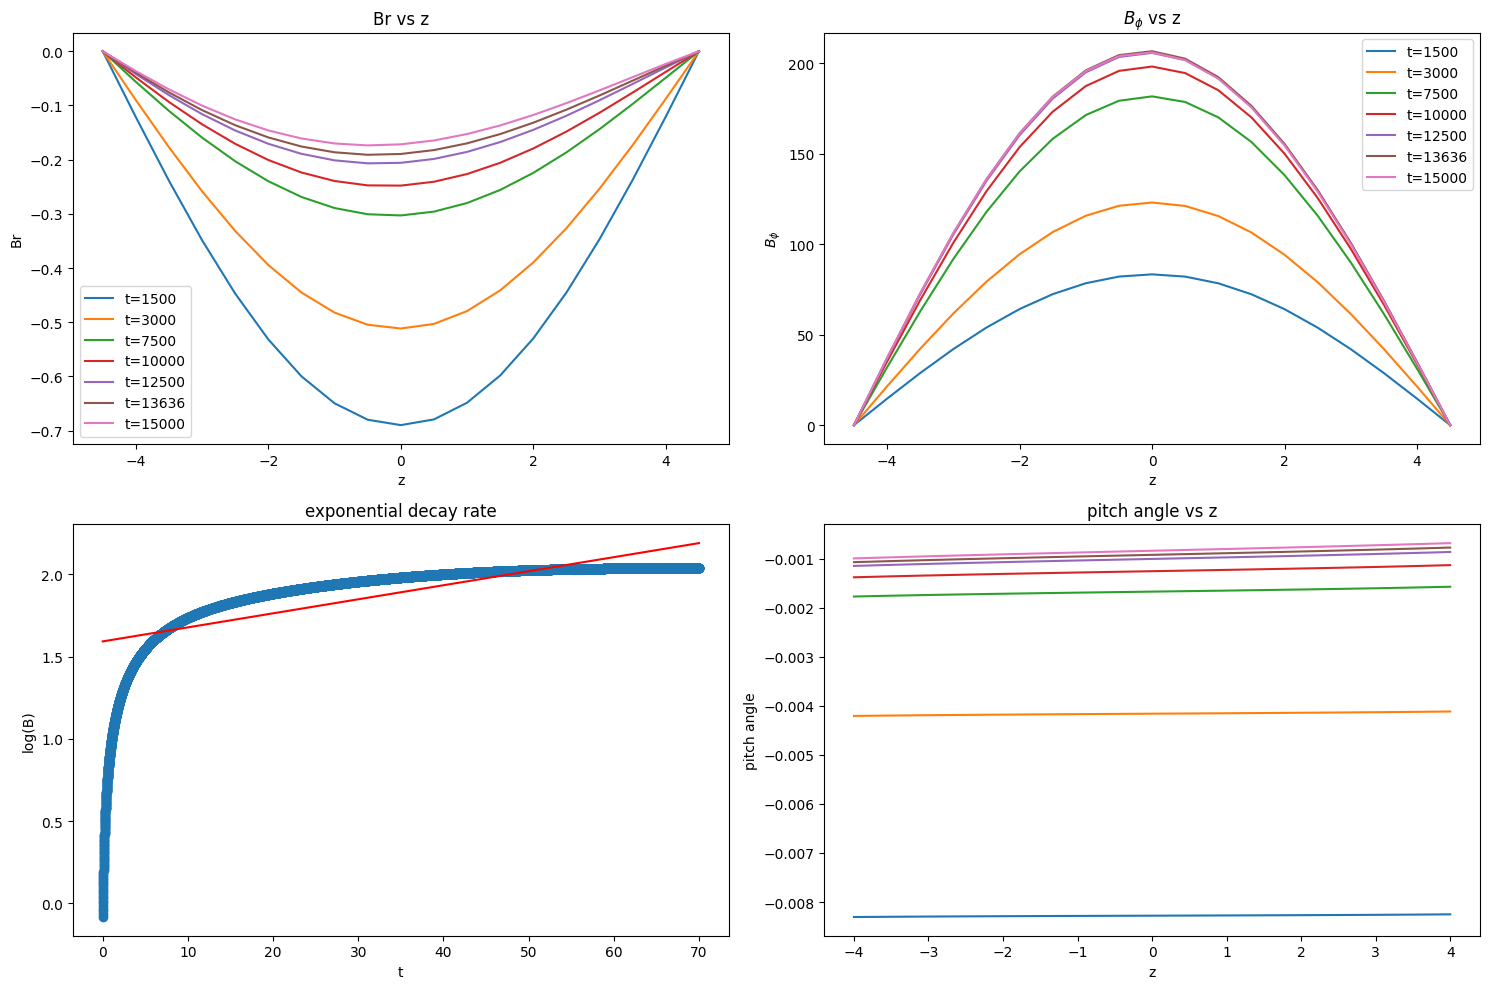

The Decay rate is 0.0197


In [121]:
# def logistic_function(t, L, k, t0):
#     return L / (1 + np.exp(-k * (t - t0)))

# # Define the range of t values
# t_values = np.linspace(0, 50, 100)

# # Choose parameters for the logistic function
# L = 50  # Maximum value
# k = 0.1  # Controls the steepness of the curve
# t0 = 0  # Time of maximum growth

# # Compute the corresponding function values
# function_values = logistic_function(t_values, L, k, t0)


def Bphi_t0(z):
    return np.cos((np.pi/2)*z/5)

def Br_t0(z):
    return np.cos((np.pi/2)*z/5+(np.pi))


# def vzfn(tv):
#     return tv/(4.1*np.sqrt(tv+0.001))

# def vzfn(tv):
#     return np.sin(tv/80)
L = 0.874 # Maximum value
k = 0.1  # Controls the steepness of the curve
t0 = 0  # Time of maximum growth
def vzfn(tv):
    return L / (1 + np.exp(-k * (tv - t0)))


def alphafn(z):
    return (2*np.sin(np.pi*z/1000000))

# def alphafn(z):
#     return (np.sin(np.pi*z/0.761))


def dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Br_t0,dz,Nz)-df(alpha*alphafn(z)*Bphi_t0,dz,Nz)-df(vzfn(tv)*Br_t0,dz,Nz))
def dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Bphi_t0,dz,Nz)+((D/alpha)*Br_t0)-df(vzfn(tv)*Bphi_t0,dz,Nz))


# z0 = 0.0  # start of spatial region in z
# zf = 10.0  # end of spatial domain in z
z0 = -5  # start of spatial region in z
zf = 5  # end of spatial domain in z

t0=0.0
tf = 70 
Nz = 21  # Number of spatial grid points
Nt = 15000  # Number of time steps
dz = (zf - z0) / (Nz - 1)  # Spatial step size
dt = tf / Nt  # Time step size



z = np.linspace(z0, zf, Nz)
t = np.linspace(t0, tf, Nt+1)

Br_t0=Br_t0(z)
Bphi_t0=Bphi_t0(z)

Bphi_z0=0
Bphi_zf=0
Br_z0=0
Br_zf=0

#print(Bphi_z0,Bphi_zf,Br_z0,Br_zf)
time_plot=[int(Nt/10),int(Nt/5),int(Nt/2),int(Nt/1.5),int(Nt/1.2),int(Nt/1.1),Nt]



# D, alpha = -5, 1
D, alpha = -17.10, 1

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)

/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


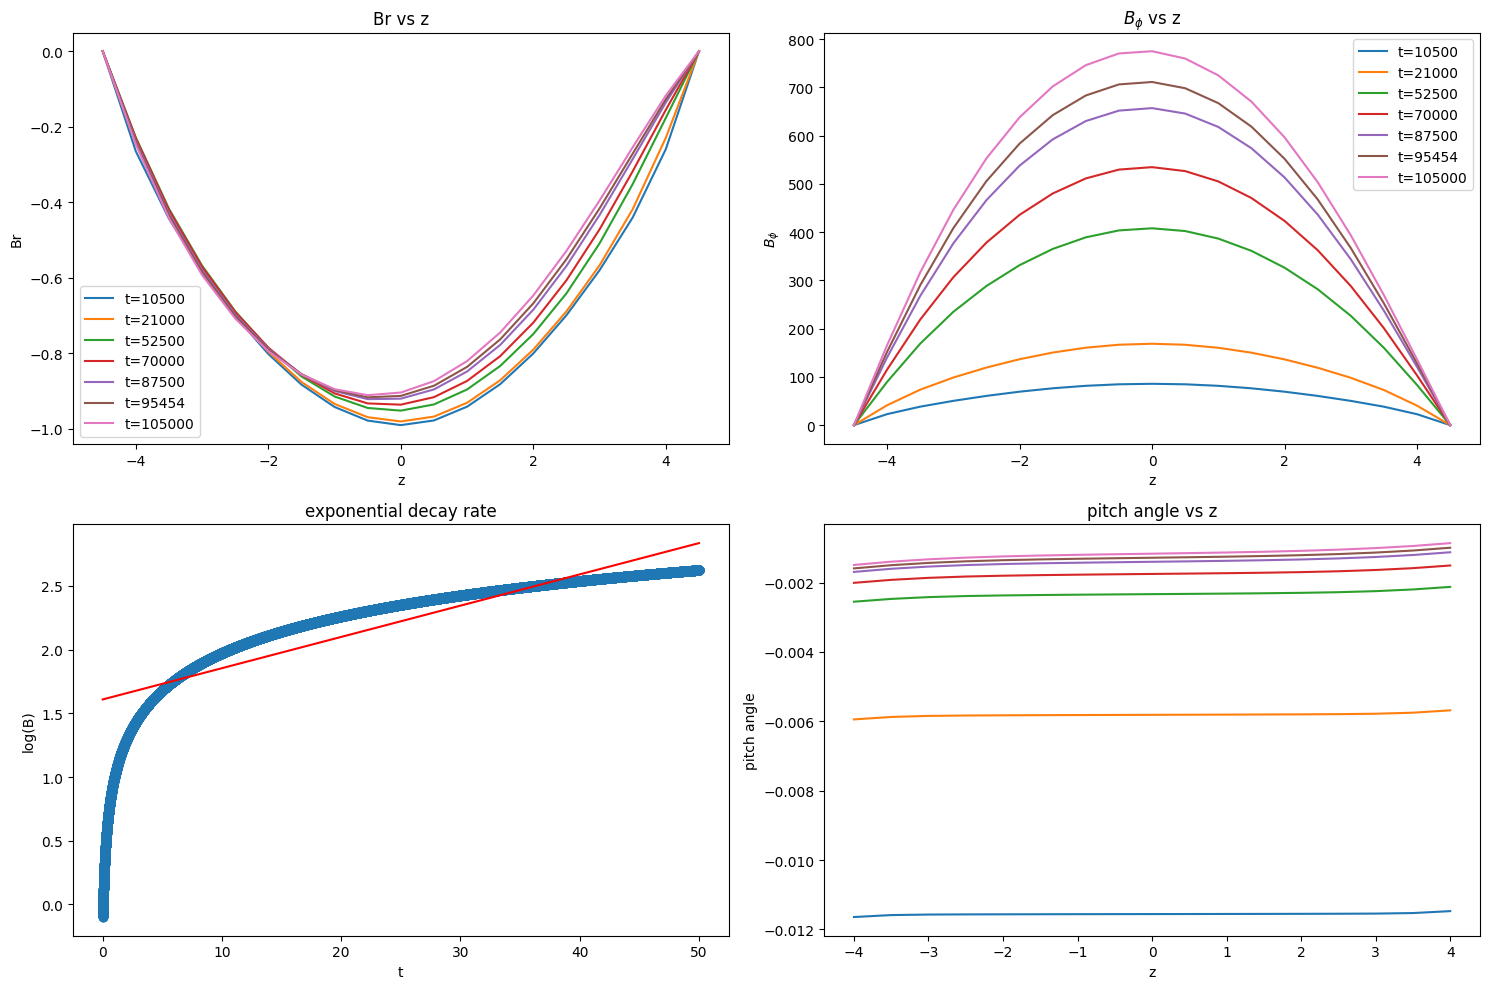

The Decay rate is 0.0565


In [161]:



def Bphi_t0(z):
    return np.cos((np.pi/2)*z/5)

def Br_t0(z):
    return np.cos((np.pi/2)*z/5+(np.pi))


# def vzfn(tv):
#     return tv/(4.1*np.sqrt(tv+0.001))

# def vzfn(tv):
#     return np.sin(tv/80)
# L = 0.874 # Maximum value
# k = 0.1  # Controls the steepness of the curve
# t0 = 0  # Time of maximum growth
# def vzfn(tv):
#     return L / (1 + np.exp(-k * (tv - t0)))

# def vzfn(tv):
#     return tv/43

def vzfn(tv):
    return 0.98

def alphafn(z):
    return (2*np.sin(np.pi*z/1000000))

# def alphafn(z):
#     return (np.sin(np.pi*z/0.761))


def dBrdt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Br_t0,dz,Nz)-df(alpha*alphafn(z)*Bphi_t0,dz,Nz)-df(vzfn(tv)*Br_t0,dz,Nz))
def dBphidt(Br_t0,Bphi_t0,z,D,alpha,dz,Nz,vzfn,tv):
    return (d2f(Bphi_t0,dz,Nz)+((D/alpha)*Br_t0)-df(vzfn(tv)*Bphi_t0,dz,Nz))


# z0 = 0.0  # start of spatial region in z
# zf = 10.0  # end of spatial domain in z
z0 = -5  # start of spatial region in z
zf = 5  # end of spatial domain in z

t0=0.0
tf = 50 
Nz = 21  # Number of spatial grid points
Nt = 105000  # Number of time steps
dz = (zf - z0) / (Nz - 1)  # Spatial step size
dt = tf / Nt  # Time step size



z = np.linspace(z0, zf, Nz)
t = np.linspace(t0, tf, Nt+1)

Br_t0=Br_t0(z)
Bphi_t0=Bphi_t0(z)

Bphi_z0=0
Bphi_zf=0
Br_z0=0
Br_zf=0

#print(Bphi_z0,Bphi_zf,Br_z0,Br_zf)
time_plot=[int(Nt/10),int(Nt/5),int(Nt/2),int(Nt/1.5),int(Nt/1.2),int(Nt/1.1),Nt]



# D, alpha = -5, 1
D, alpha = -17.10, 1

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)

### when $V_z$ is not large enough

/tmp/ipykernel_17514/2150087775.py:73: RuntimeWarning: invalid value encountered in divide
  pitch=np.arctan(np.array(Br)/np.array(Bphi))


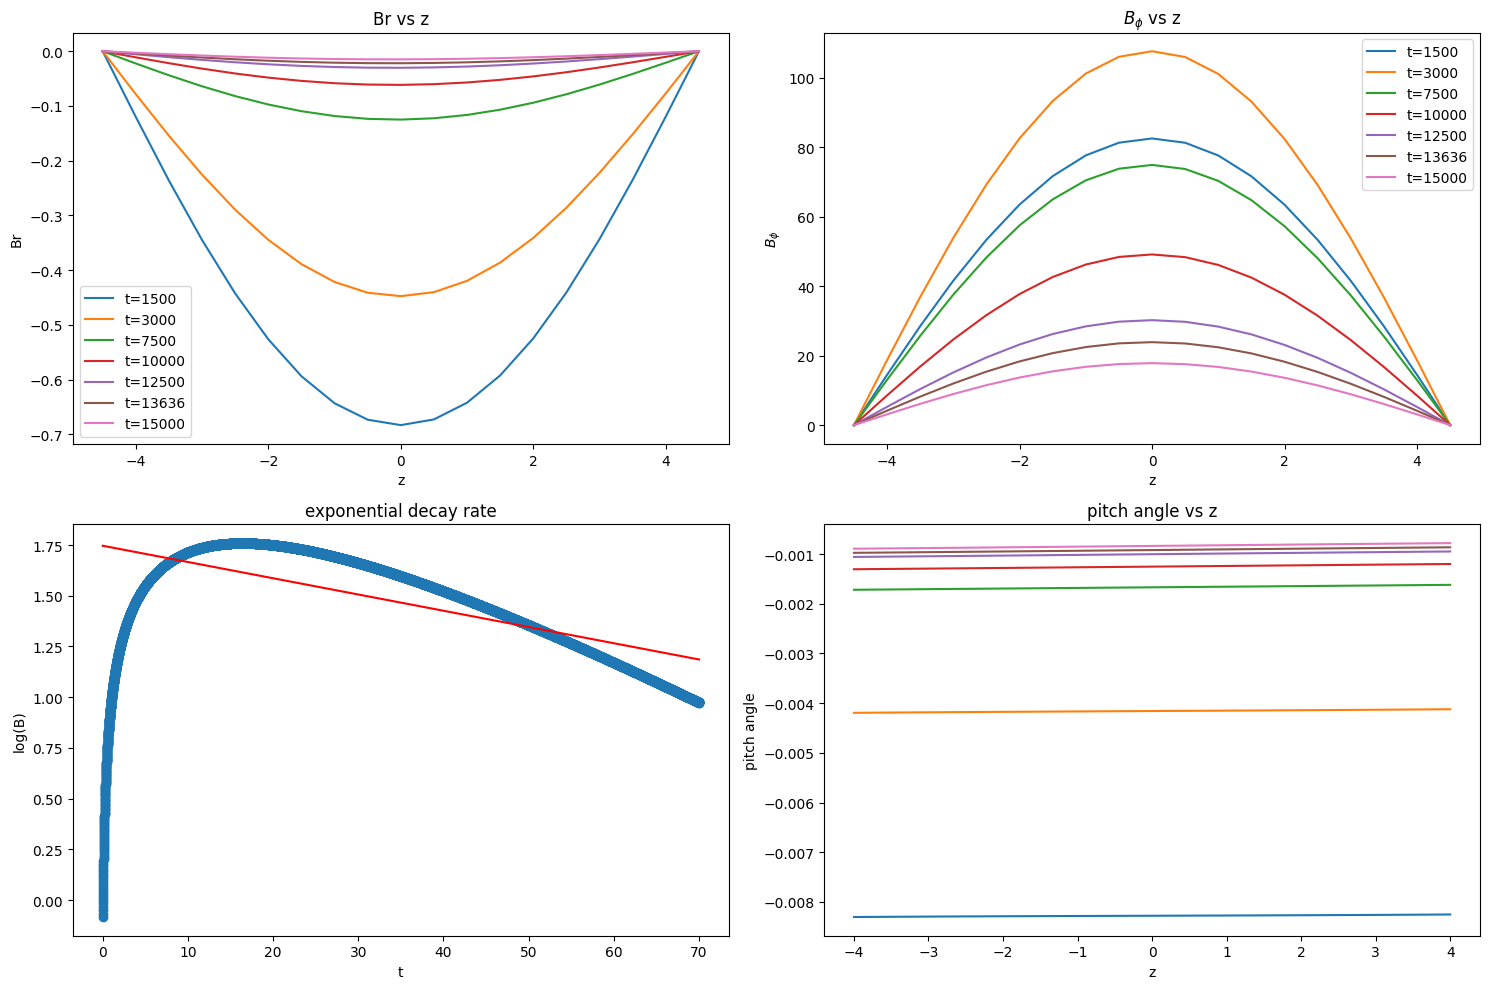

The Decay rate is -0.0184


In [124]:

def vzfn(tv):
    return 0.5

plotfn(*solve2(Br_t0,Bphi_t0,Nz,Nt,time_plot,Bphi_z0,Bphi_zf,Br_z0,Br_zf,D),time_plot,t,z,Nz)
